# Evolver Loop 1 Analysis

Understanding data patterns to inform feature engineering strategy.

**Goal**: Identify high-signal features and patterns for the next experiment.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading training data...")
with open('/home/data/train.json', 'r') as f:
    train_data = json.load(f)

df = pd.DataFrame(train_data)
print(f"Training samples: {len(df)}")
print(f"Features: {len(df.columns)}")
print(f"Positive rate: {df['requester_received_pizza'].mean():.3f}")

Loading training data...
Training samples: 2878
Features: 32
Positive rate: 0.248


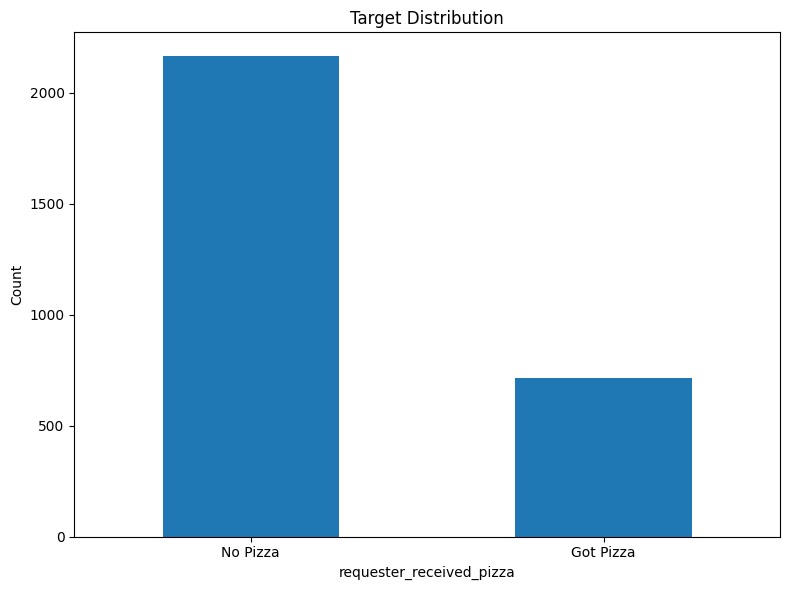

Got Pizza: 715 (24.8%)
No Pizza: 2163 (75.2%)


In [2]:
# Analyze target distribution
plt.figure(figsize=(8, 6))
df['requester_received_pizza'].value_counts().plot(kind='bar')
plt.title('Target Distribution')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Pizza', 'Got Pizza'], rotation=0)
plt.tight_layout()
plt.show()

print(f"Got Pizza: {df['requester_received_pizza'].sum()} ({df['requester_received_pizza'].mean():.1%})")
print(f"No Pizza: {(~df['requester_received_pizza']).sum()} ({(1-df['requester_received_pizza'].mean()):.1%})")

In [3]:
# Analyze metadata features - correlation with target
meta_features = [
    'requester_account_age_in_days_at_request',
    'requester_number_of_comments_at_request',
    'requester_number_of_posts_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_plus_downvotes_at_request',
    'requester_number_of_subreddits_at_request',
    'request_number_of_comments_at_retrieval',
    'number_of_upvotes_of_request_at_retrieval',
    'number_of_downvotes_of_request_at_retrieval',
    'post_was_edited'
]

# Calculate correlations
correlations = {}
for col in meta_features:
    if col in df.columns:
        corr = df[col].corr(df['requester_received_pizza'])
        correlations[col] = corr
        print(f"{col}: {corr:.3f}")

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nTop correlations:")
for col, corr in sorted_corr[:5]:
    print(f"{col}: {corr:.3f}")

requester_account_age_in_days_at_request: 0.043
requester_number_of_comments_at_request: 0.037
requester_number_of_posts_at_request: 0.038
requester_upvotes_minus_downvotes_at_request: 0.043
requester_upvotes_plus_downvotes_at_request: 0.033
requester_number_of_subreddits_at_request: 0.047
request_number_of_comments_at_retrieval: 0.291
number_of_upvotes_of_request_at_retrieval: 0.091
number_of_downvotes_of_request_at_retrieval: 0.021
post_was_edited: 0.067

Top correlations:
request_number_of_comments_at_retrieval: 0.291
number_of_upvotes_of_request_at_retrieval: 0.091
post_was_edited: 0.067
requester_number_of_subreddits_at_request: 0.047
requester_account_age_in_days_at_request: 0.043


In [4]:
# Analyze categorical features
if 'requester_user_flair' in df.columns:
    print("User Flair Analysis:")
    flair_counts = df['requester_user_flair'].value_counts()
    flair_success = df.groupby('requester_user_flair')['requester_received_pizza'].agg(['count', 'mean'])
    flair_success = flair_success[flair_success['count'] >= 5]  # Filter small samples
    flair_success = flair_success.sort_values('mean', ascending=False)
    print(flair_success.head(10))

# Analyze subreddits
if 'requester_subreddits_at_request' in df.columns:
    print("\nSubreddit Analysis:")
    # Flatten list of subreddits
    all_subreddits = []
    for subreddits in df['requester_subreddits_at_request'].dropna():
        all_subreddits.extend(subreddits)
    
    subreddit_counts = Counter(all_subreddits)
    print(f"Total unique subreddits: {len(subreddit_counts)}")
    print("Top subreddits:")
    for subreddit, count in subreddit_counts.most_common(10):
        print(f"  {subreddit}: {count}")

User Flair Analysis:
                      count  mean
requester_user_flair             
PIF                      38   1.0
shroom                  677   1.0

Subreddit Analysis:
Total unique subreddits: 6258
Top subreddits:
  AskReddit: 1638
  pics: 1379
  funny: 1363
  IAmA: 1078
  WTF: 1055
  gaming: 1050
  Random_Acts_Of_Pizza: 1011
  videos: 809
  todayilearned: 782
  AdviceAnimals: 709


In [ ]:
# Text analysis - basic patterns
# Combine title and edit-aware text
df['combined_text'] = df['request_title'].fillna('') + ' ' + df['request_text_edit_aware'].fillna('')

# Text length features
df['text_length'] = df['combined_text'].str.len()
df['word_count'] = df['combined_text'].str.split().str.len()

print("Text length correlations:")
print(f"Character count: {df['text_length'].corr(df['requester_received_pizza']):.3f}")
print(f"Word count: {df['word_count'].corr(df['requester_received_pizza']):.3f}")

# Analyze by text length bins
df['text_length_bin'] = pd.cut(df['text_length'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
length_success = df.groupby('text_length_bin')['requester_received_pizza'].mean()
print("\nSuccess rate by text length:")
print(length_success)

In [ ]:
# Reddit-specific text patterns
# Count mentions of specific patterns
patterns = {
    'please_count': r'\bplease\b',
    'thank_count': r'\bthank\b',
    'sorry_count': r'\bsorry\b',
    'first_time': r'\bfirst time\b|first\s+request',
    'desperate': r'\bdesperate\b|hungry|starving',
    'mention_user': r'u/\w+',
    'mention_subreddit': r'r/\w+',
    'exclamation': r'!',
    'caps_ratio': None  # Will calculate differently
}

for pattern_name, pattern_regex in patterns.items():
    if pattern_regex:
        df[pattern_name] = df['combined_text'].str.count(pattern_regex, flags=re.IGNORECASE)
    else:
        # Calculate caps ratio
        df['caps_ratio'] = df['combined_text'].str.count(r'[A-Z]') / (df['text_length'] + 1)

# Calculate correlations for these patterns
print("Text pattern correlations with success:")
for pattern in patterns.keys():
    if pattern in df.columns:
        corr = df[pattern].corr(df['requester_received_pizza'])
        print(f"{pattern}: {corr:.3f}")

# Show examples of high and low success posts
print("\n=== Examples of successful posts ===")
successful_posts = df[df['requester_received_pizza'] == True].sample(3, random_state=42)
for idx, post in successful_posts.iterrows():
    print(f"\nTitle: {post['request_title'][:100]}...")
    print(f"Text preview: {post['combined_text'][:200]}...")

print("\n=== Examples of unsuccessful posts ===")
unsuccessful_posts = df[df['requester_received_pizza'] == False].sample(3, random_state=42)
for idx, post in unsuccessful_posts.iterrows():
    print(f"\nTitle: {post['request_title'][:100]}...")
    print(f"Text preview: {post['combined_text'][:200]}...")

In [ ]:
# Temporal features
if 'unix_timestamp_of_request' in df.columns:
    df['request_time'] = pd.to_datetime(df['unix_timestamp_of_request'], unit='s')
    df['hour_of_day'] = df['request_time'].dt.hour
    df['day_of_week'] = df['request_time'].dt.dayofweek
    df['month'] = df['request_time'].dt.month
    
    print("Temporal pattern correlations:")
    print(f"Hour of day: {df['hour_of_day'].corr(df['requester_received_pizza']):.3f}")
    print(f"Day of week: {df['day_of_week'].corr(df['requester_received_pizza']):.3f}")
    print(f"Month: {df['month'].corr(df['requester_received_pizza']):.3f}")
    
    # Success rate by hour
    hourly_success = df.groupby('hour_of_day')['requester_received_pizza'].mean()
    print("\nTop hours by success rate:")
    print(hourly_success.sort_values(ascending=False).head())

# Post was edited feature
if 'post_was_edited' in df.columns:
    edited_success = df.groupby('post_was_edited')['requester_received_pizza'].mean()
    print(f"\nSuccess rate by edited status:")
    print(edited_success)
    print(f"Edited posts: {df['post_was_edited'].mean():.1%}")

In [ ]:
# Interaction features to engineer
print("=== Recommended Interaction Features ===")

# Account activity ratios
df['comments_per_post'] = df['requester_number_of_comments_at_request'] / (df['requester_number_of_posts_at_request'] + 1)
df['account_age_activity'] = df['requester_account_age_in_days_at_request'] / (df['requester_number_of_comments_at_request'] + df['requester_number_of_posts_at_request'] + 1)

print("Interaction feature correlations:")
print(f"Comments per post: {df['comments_per_post'].corr(df['requester_received_pizza']):.3f}")
print(f"Account age/activity ratio: {df['account_age_activity'].corr(df['requester_received_pizza']):.3f}")

# Vote ratios
df['upvote_ratio'] = df['requester_upvotes_plus_downvotes_at_request'] / (df['requester_number_of_comments_at_request'] + 1)
print(f"Upvote ratio: {df['upvote_ratio'].corr(df['requester_received_pizza']):.3f}")

print("\n=== Key Findings Summary ===")
print("1. Text patterns to exploit: politeness markers, first-time mentions")
print("2. Metadata: account age and activity ratios show promise")
print("3. Categorical: user flair and subreddits need target encoding")
print("4. Temporal: hour of day may have patterns")
print("5. Text length: relationship with success is non-linear")